Below is boilerplate items for each of these analysis notebooks.

In [1]:
DATA_FOLDER = 'data/fsm/'

In [2]:
from IPython.display import display, HTML
import numpy as np

Import my own custom handlers

In [3]:
import altair as alt
alt.renderers.enable('notebook')

from viz import visualize_seqs
from model_stats import ModelStats

results = ModelStats()

# Data - FSM

The data for fsm is based off of the below automaton.

![alt text](data/fsm/IrregularFSM.png "Title")

Read data

IMPORTANT: Adding 1 to each event so that the events start at 1.  This is important for when later using one-hot models and using 0 as a padding.

In [4]:
file_index = 1
events = {}
times = {}

for data_type in ['train', 'test']:
    with open(DATA_FOLDER + 'event-' + str(file_index) + '-' + data_type + '.txt') as f_events:
        events[data_type] = [[int(y) + 1 for y in x.split()] for x in f_events]
        
    with open(DATA_FOLDER + 'time-' + str(file_index) + '-' + data_type + '.txt') as f_times:
        times[data_type] = [[float(y) for y in x.split()] for x in f_times]

# Models without Time

Errors for these models are represented as a percent where:

number wrong / total predictions = error%

## Get Event Stats

In [5]:
event_dict = {}
for data_type in ['train', 'test']:
    for seq in events[data_type]:
        for event in seq:
            if event not in event_dict:
                event_dict[event] = 0
            event_dict[event] += 1
            
all_events = list(event_dict.keys())
num_events = len(all_events)
max_event = max(all_events)
print('Events', all_events)
print('Num events', num_events)
print('Max event', max_event)

print('')
print('-' * 8)
print('Event counts')
print(event_dict)

Events [1, 2, 3, 4, 5]
Num events 5
Max event 5

--------
Event counts
{1: 1200, 2: 1200, 3: 1200, 4: 1200, 5: 1200}


# Helper Functions

In [6]:
def compute_error(y_true, y_pred):
    num_error = 0
    total = 0
    for s, seq in enumerate(y_true):
        total += len(seq) - 1
        for e, event in enumerate(seq[1:]):
            if event != y_pred[s][e]:
                num_error += 1
                
    return (num_error / total) * 100

def show_results(name, train_pred, test_pred):
    print('----')
    train_err = compute_error(events['train'], train_pred)
    test_err = compute_error(events['test'], test_pred)
    results.add_stat(name, {'train': train_err, 'test': test_err}, None)
    print('Train Error: ', train_err)
    print('Test Error: ', test_err)
    display(HTML('<h3>Train</h3>'))
    display(HTML(visualize_seqs(events['train'], train_pred)))
    display(HTML('<h3>Test</h3>'))
    display(HTML(visualize_seqs(events['test'], train_pred)))

In [7]:
def convert_flat(predictions, data_type):
    pred = []
    index = 0
    for s, seq in enumerate(events[data_type]):
        start_index = index
        index += len(seq) - 1
        pred.append(predictions[start_index:index])
        
    return pred

In [8]:
def convert_nn_seq(predictions, data_type):
    pred = []
    for s, seq in enumerate(events[data_type]):
        seq_len = len(seq) - 1
        pred.append(predictions[s][-seq_len:].tolist())
        
    return pred

# Baselines

## Majority Predictor

Source: https://github.com/dunan/NeuralPointProcess/blob/master/code/baselines/majority_predictor/event_majority_baseline.py

In [9]:
from collections import Counter

cnt = Counter()
for seq in events['train']:
    for event in seq:
        cnt[event] += 1

top = cnt.most_common(1)[0][0]
print('Most commom event is', top)

train_pred = [[top for event in seq[1:]] for seq in events['train']]
test_pred = [[top for event in seq[1:]] for seq in events['test']]
show_results('Majority', train_pred, test_pred)

Most commom event is 1
----
Train Error:  100.0
Test Error:  100.0


## Markov Chain

In [10]:
from markov_chain import predict_mc_model

### MC-1

In [11]:
preds = predict_mc_model(events, 1)
show_results('MC-1', preds['train'], preds['test'])

----
Train Error:  37.275000000000006
Test Error:  40.5


### MC-2

In [12]:
preds = predict_mc_model(events, 2)
show_results('MC-2', preds['train'], preds['test'])

----
Train Error:  37.425000000000004
Test Error:  38.5


### MC-3

In [13]:
preds = predict_mc_model(events, 3)
show_results('MC-3', preds['train'], preds['test'])

----
Train Error:  50.0
Test Error:  50.0


### MC-4

In [14]:
preds = predict_mc_model(events, 4)
show_results('MC-4', preds['train'], preds['test'])

----
Train Error:  75.0
Test Error:  75.0


## Chunking Models

In [15]:
CHUNK_SIZE = 5

In [16]:
x = {}
y = {}

for data_type in ['train', 'test']:
    x[data_type] = []
    y[data_type] = []
    for seq in events[data_type]:
        current_seq = [0] * (CHUNK_SIZE - 1) + seq
        for e, event in enumerate(current_seq):
            if e >= CHUNK_SIZE:
                y[data_type].append(event)
                index_lookback = e - CHUNK_SIZE
                x[data_type].append(current_seq[index_lookback:e])

    x[data_type] = np.asarray(x[data_type])
    y[data_type] = np.asarray(y[data_type])

## Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x['train'], y['train'])
train_pred = convert_flat(model.predict(x['train']), 'train')
test_pred = convert_flat(model.predict(x['test']), 'test')

print('Without rounding')
show_results('LinReg', train_pred, test_pred)

Without rounding
----
Train Error:  100.0
Test Error:  100.0


In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x['train'], y['train'])
train_pred = convert_flat(np.round(model.predict(x['train'])), 'train')
test_pred = convert_flat(np.round(model.predict(x['test'])), 'test')

print('With rounding')
show_results('LinRegRound', train_pred, test_pred)

With rounding
----
Train Error:  37.425000000000004
Test Error:  38.5


Going to normalize before inputting to LinearRegression

In [19]:
from sklearn.linear_model import LinearRegression

x_train = x['train'] / max_event
y_train = y['train'] / max_event
x_test = x['test'] / max_event
y_test = y['test'] / max_event

model = LinearRegression()
model.fit(x_train, y_train)
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

train_pred = np.round(train_pred * max_event)
test_pred = np.round(test_pred * max_event)

train_pred = convert_flat(train_pred, 'train')
test_pred = convert_flat(test_pred, 'test')


print('With rounding')
show_results('LinRegRoundNorm', train_pred, test_pred)

With rounding
----
Train Error:  37.425000000000004
Test Error:  38.5


## Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x['train'], y['train'])
train_pred = convert_flat(model.predict(x['train']), 'train')
test_pred = convert_flat(model.predict(x['test']), 'test')

show_results('DecisionTree', train_pred, test_pred)

----
Train Error:  12.425
Test Error:  13.5


Visualize the decision tree

In [21]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydot

# model_dot = export_graphviz(model,
#                             out_file=None,
#                             filled=True,
#                             rounded=True)
# 
# graph = pydot.graph_from_dot_data(model_dot)
# display(Image(graph[0].create_png()))

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x['train'], y['train'])
train_pred = convert_flat(model.predict(x['train']), 'train')
test_pred = convert_flat(model.predict(x['test']), 'test')

show_results('RandomForest', train_pred, test_pred)

----
Train Error:  12.575
Test Error:  11.5


## AdaBoost Classifier

In [23]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(x['train'], y['train'])
train_pred = convert_flat(model.predict(x['train']), 'train')
test_pred = convert_flat(model.predict(x['test']), 'test')

show_results('AdaBoost', train_pred, test_pred)

----
Train Error:  25.0
Test Error:  25.0


# One-Hot Data

Convert the data into one-hot so that rather than using an integer for the category, use a vector:

2 ===>  <0, 0, 1, 0, 0>

In [24]:
x = {}
y = {}

for data_type in ['train', 'test']:
    x[data_type] = []
    y[data_type] = []
    for seq in events[data_type]:
        current_seq = [-1] * (CHUNK_SIZE - 1) + seq
        for e, event in enumerate(current_seq):
            if e >= CHUNK_SIZE:
                y[data_type].append(event)
                index_lookback = e - CHUNK_SIZE
                
                current_x = []
                for back_event in current_seq[index_lookback:e]:
                    vector = [0] * max_event
                    if back_event > 0:
                        vector[back_event-1] = 1
                    current_x += vector
                x[data_type].append(current_x)

    x[data_type] = np.asarray(x[data_type])
    y[data_type] = np.asarray(y[data_type])

## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x['train'], y['train'])
train_pred = convert_flat(model.predict(x['train']), 'train')
test_pred = convert_flat(model.predict(x['test']), 'test')

show_results('DecisionTreeOneHot', train_pred, test_pred)

----
Train Error:  12.425
Test Error:  13.5


## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x['train'], y['train'])
train_pred = convert_flat(model.predict(x['train']), 'train')
test_pred = convert_flat(model.predict(x['test']), 'test')

show_results('RandomForestOneHot', train_pred, test_pred)

----
Train Error:  12.425
Test Error:  13.5


# Neural Networks

We are going to try a bunch of different network configurations so let's import stuff that we'll need.

In [27]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

D:\Users\fjd10\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Regular FeedForward Neural Network

We need to alter the data for the FNN, such that the y variable is all one-hot.

In [28]:
y_train = np.zeros((y['train'].shape[0], num_events))
y_train[np.arange(y['train'].shape[0]), y['train'] - 1] = 1

y_test = np.zeros((y['test'].shape[0], num_events))
y_test[np.arange(y['test'].shape[0]), y['test'] - 1] = 1

#### Single - tanh

A single hidden layer using tanh activation

In [29]:
model = Sequential()
model.add(layers.Dense(50, activation='tanh', batch_input_shape=(None, x['train'].shape[1])))
model.add(layers.Dense(num_events, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y_train, validation_data=(x['test'], y_test), batch_size=100, epochs=3)

train_pred = convert_flat(np.argmax(model.predict(x['train']), axis=1) + 1, 'train')
test_pred = convert_flat(np.argmax(model.predict(x['test']), axis=1) + 1, 'test')
show_results('FNN-SingleTanh', train_pred, test_pred)

Train on 4000 samples, validate on 800 samples
Epoch 1/3
4000/4000 [==============================] - 0s 55us/step - loss: 1.4884 - acc: 0.3507 - val_loss: 1.1559 - val_acc: 0.7300
Epoch 2/3
4000/4000 [==============================] - 0s 11us/step - loss: 0.9292 - acc: 0.8163 - val_loss: 0.7414 - val_acc: 0.8650
Epoch 3/3
4000/4000 [==============================] - 0s 10us/step - loss: 0.6075 - acc: 0.8758 - val_loss: 0.4937 - val_acc: 0.8650
----
Train Error:  12.425
Test Error:  13.5


#### Single - linear

A single hidden layer using linear activation

In [30]:
model = Sequential()
model.add(layers.Dense(50, activation='linear', batch_input_shape=(None, x['train'].shape[1])))
model.add(layers.Dense(num_events, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y_train, validation_data=(x['test'], y_test), batch_size=100, epochs=3)

train_pred = convert_flat(np.argmax(model.predict(x['train']), axis=1) + 1, 'train')
test_pred = convert_flat(np.argmax(model.predict(x['test']), axis=1) + 1, 'test')
show_results('FNN-SingleLinear', train_pred, test_pred)

Train on 4000 samples, validate on 800 samples
Epoch 1/3
4000/4000 [==============================] - 0s 75us/step - loss: 1.2146 - acc: 0.6692 - val_loss: 0.9220 - val_acc: 0.8650
Epoch 2/3
4000/4000 [==============================] - 0s 11us/step - loss: 0.7300 - acc: 0.8758 - val_loss: 0.5752 - val_acc: 0.8650
Epoch 3/3
4000/4000 [==============================] - 0s 11us/step - loss: 0.4705 - acc: 0.8758 - val_loss: 0.3902 - val_acc: 0.8650
----
Train Error:  12.425
Test Error:  13.5


#### Single - relu

A single hidden layer using relu activation

In [31]:
model = Sequential()
model.add(layers.Dense(50, activation='relu', batch_input_shape=(None, x['train'].shape[1])))
model.add(layers.Dense(num_events, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y_train, validation_data=(x['test'], y_test), batch_size=100, epochs=3)

train_pred = convert_flat(np.argmax(model.predict(x['train']), axis=1) + 1, 'train')
test_pred = convert_flat(np.argmax(model.predict(x['test']), axis=1) + 1, 'test')
show_results('FNN-SingleRelu', train_pred, test_pred)

Train on 4000 samples, validate on 800 samples
Epoch 1/3
4000/4000 [==============================] - 0s 97us/step - loss: 1.5048 - acc: 0.4763 - val_loss: 1.2881 - val_acc: 0.7500
Epoch 2/3
4000/4000 [==============================] - 0s 12us/step - loss: 1.0992 - acc: 0.7620 - val_loss: 0.9070 - val_acc: 0.8850
Epoch 3/3
4000/4000 [==============================] - 0s 11us/step - loss: 0.7402 - acc: 0.8742 - val_loss: 0.5870 - val_acc: 0.8850
----
Train Error:  12.575
Test Error:  11.5


#### Multiple - tanh

Multiple hidden layers with tanh activation

In [32]:
model = Sequential()
model.add(layers.Dense(50, activation='tanh', batch_input_shape=(None, x['train'].shape[1])))
model.add(layers.Dense(15, activation='tanh'))
model.add(layers.Dense(num_events, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y_train, validation_data=(x['test'], y_test), batch_size=100, epochs=3)

train_pred = convert_flat(np.argmax(model.predict(x['train']), axis=1) + 1, 'train')
test_pred = convert_flat(np.argmax(model.predict(x['test']), axis=1) + 1, 'test')
show_results('FNN-MultipleTanh', train_pred, test_pred)

Train on 4000 samples, validate on 800 samples
Epoch 1/3
4000/4000 [==============================] - 0s 115us/step - loss: 1.0146 - acc: 0.7957 - val_loss: 0.6722 - val_acc: 0.8850
Epoch 2/3
4000/4000 [==============================] - 0s 12us/step - loss: 0.5056 - acc: 0.8697 - val_loss: 0.3824 - val_acc: 0.8850
Epoch 3/3
4000/4000 [==============================] - 0s 12us/step - loss: 0.3246 - acc: 0.8697 - val_loss: 0.2791 - val_acc: 0.8850
----
Train Error:  12.575
Test Error:  11.5


#### Multiple - linear

Multiple hidden layers with linear activation

In [33]:
model = Sequential()
model.add(layers.Dense(50, activation='linear', batch_input_shape=(None, x['train'].shape[1])))
model.add(layers.Dense(15, activation='linear'))
model.add(layers.Dense(num_events, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y_train, validation_data=(x['test'], y_test), batch_size=100, epochs=3)

train_pred = convert_flat(np.argmax(model.predict(x['train']), axis=1) + 1, 'train')
test_pred = convert_flat(np.argmax(model.predict(x['test']), axis=1) + 1, 'test')
show_results('FNN-MultipleLinear', train_pred, test_pred)

Train on 4000 samples, validate on 800 samples
Epoch 1/3
4000/4000 [==============================] - 0s 121us/step - loss: 1.1222 - acc: 0.7115 - val_loss: 0.6886 - val_acc: 0.8650
Epoch 2/3
4000/4000 [==============================] - 0s 12us/step - loss: 0.4600 - acc: 0.8727 - val_loss: 0.3104 - val_acc: 0.8850
Epoch 3/3
4000/4000 [==============================] - 0s 11us/step - loss: 0.2585 - acc: 0.8810 - val_loss: 0.2240 - val_acc: 0.8850
----
Train Error:  12.575
Test Error:  11.5


#### Multiple - relu

Multiple hidden layers with relu activation

In [34]:
model = Sequential()
model.add(layers.Dense(50, activation='relu', batch_input_shape=(None, x['train'].shape[1])))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(num_events, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y_train, validation_data=(x['test'], y_test), batch_size=100, epochs=3)

train_pred = convert_flat(np.argmax(model.predict(x['train']), axis=1) + 1, 'train')
test_pred = convert_flat(np.argmax(model.predict(x['test']), axis=1) + 1, 'test')
show_results('FNN-MultipleRelu', train_pred, test_pred)

Train on 4000 samples, validate on 800 samples
Epoch 1/3
4000/4000 [==============================] - 1s 137us/step - loss: 1.4668 - acc: 0.6175 - val_loss: 1.3040 - val_acc: 0.7500
Epoch 2/3
4000/4000 [==============================] - 0s 24us/step - loss: 1.1332 - acc: 0.8202 - val_loss: 0.9541 - val_acc: 0.8650
Epoch 3/3
4000/4000 [==============================] - 0s 13us/step - loss: 0.7813 - acc: 0.8757 - val_loss: 0.6198 - val_acc: 0.8650
----
Train Error:  12.425
Test Error:  13.5


# Entire Sequences

Instead of using a lookback of CHUNK_SIZE, going to input the entire user history.  (Will use CNN and RNN for this.)

Padding the sequences with 0's at the beginning

Sequence Data

In [35]:
x = {}
y = {}

for data_type in ['train', 'test']:
    x[data_type] = []
    y[data_type] = []
    for seq in events[data_type]:
        x[data_type].append(seq[:-1])
        y[data_type].append(seq[1:])

    x[data_type] = np.asarray(x[data_type])
    y[data_type] = np.asarray(y[data_type])

In [36]:
# Find the max user length
user_lengths = [len(seq) for seq in events['train']] + [len(seq) for seq in events['test']]
user_length_counts = {}
for length in user_lengths:
    if length not in user_length_counts:
        user_length_counts[length] = 0
        
    user_length_counts[length] += 1
user_lengths = list(set(user_lengths))
user_lengths = sorted(user_lengths, reverse=True)
max_user_length = max(user_lengths)

print('Max Seq Length', max_user_length)
# print(user_lengths)

Max Seq Length 5


Subtract one from x

In [37]:
for data_type in ['train', 'test']:
    x[data_type] = [[event - 1 for event in seq] for seq in x[data_type]]

In [38]:
# Pad sequences
from keras.preprocessing import sequence

for data_type in ['train', 'test']:
    x[data_type] = sequence.pad_sequences(x[data_type], maxlen=max_user_length)
    y[data_type] = sequence.pad_sequences(y[data_type], maxlen=max_user_length)

y variable needs to be one-hot for everything.  (x will be made one-hot later for different models)

In [39]:
num_events = 22
one_hot = np.eye(num_events)
for data_type in ['train', 'test']:
    y[data_type] = [[one_hot[event-1] if event > 0 else np.zeros(num_events) for event in seq] for seq in y[data_type]]
    y[data_type] = np.asarray(y[data_type])

## Embedding Models

### Convolutional Neural Network (CNN)

Using the model found here: https://github.com/mhjabreel/CharCnn_Keras/blob/master/models/char_cnn_kim.py

*REMOVED*

### RNN Cell

In [40]:
model = Sequential()
model.add(layers.Embedding(num_events, 128, mask_zero=True))
model.add(layers.Masking(mask_value=0.))
model.add(layers.SimpleRNN(50, activation='tanh', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(num_events, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=3)

train_pred = convert_nn_seq(np.argmax(model.predict(x['train']), axis=2) + 1, 'train')
test_pred = convert_nn_seq(np.argmax(model.predict(x['test']), axis=2) + 1, 'test')
show_results('RNN-Embedded',train_pred, test_pred)

Train on 1000 samples, validate on 200 samples
Epoch 1/3
1000/1000 [==============================] - 1s 889us/step - loss: 2.2254 - acc: 0.3400 - val_loss: 1.9041 - val_acc: 0.4000
Epoch 2/3
1000/1000 [==============================] - 0s 116us/step - loss: 1.5957 - acc: 0.4600 - val_loss: 1.2360 - val_acc: 0.6000
Epoch 3/3
1000/1000 [==============================] - 0s 95us/step - loss: 1.0009 - acc: 0.6602 - val_loss: 0.7472 - val_acc: 0.7080
----
Train Error:  12.575
Test Error:  11.5


In [41]:
model = Sequential()
model.add(layers.Embedding(num_events, 512, mask_zero=True))
model.add(layers.Masking(mask_value=0.))
model.add(layers.SimpleRNN(50, activation='tanh', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.TimeDistributed(layers.Dense(num_events, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=3)

train_pred = convert_nn_seq(np.argmax(model.predict(x['train']), axis=2) + 1, 'train')
test_pred = convert_nn_seq(np.argmax(model.predict(x['test']), axis=2) + 1, 'test')
show_results('RNN-EmbeddedForwards', train_pred, test_pred)

Train on 1000 samples, validate on 200 samples
Epoch 1/3
1000/1000 [==============================] - 1s 1ms/step - loss: 2.0956 - acc: 0.3504 - val_loss: 1.6470 - val_acc: 0.6000
Epoch 2/3
1000/1000 [==============================] - 0s 139us/step - loss: 1.4093 - acc: 0.6000 - val_loss: 1.1763 - val_acc: 0.6000
Epoch 3/3
1000/1000 [==============================] - 0s 137us/step - loss: 1.0359 - acc: 0.6000 - val_loss: 0.8878 - val_acc: 0.6000
----
Train Error:  25.0
Test Error:  25.0


### LSTM Cell

In [42]:
model = Sequential()
model.add(layers.Embedding(num_events, 128, mask_zero=True))
model.add(layers.Masking(mask_value=0.))
model.add(layers.LSTM(50, activation='tanh', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(num_events, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=3)

train_pred = convert_nn_seq(np.argmax(model.predict(x['train']), axis=2) + 1, 'train')
test_pred = convert_nn_seq(np.argmax(model.predict(x['test']), axis=2) + 1, 'test')
show_results('LSTM-Embedded',train_pred, test_pred)

Train on 1000 samples, validate on 200 samples
Epoch 1/3
1000/1000 [==============================] - 1s 1ms/step - loss: 2.4253 - acc: 0.4002 - val_loss: 2.3610 - val_acc: 0.6000
Epoch 2/3
1000/1000 [==============================] - 0s 115us/step - loss: 2.2797 - acc: 0.5318 - val_loss: 2.1486 - val_acc: 0.4920
Epoch 3/3
1000/1000 [==============================] - 0s 111us/step - loss: 1.9605 - acc: 0.5006 - val_loss: 1.6682 - val_acc: 0.2920
----
Train Error:  62.425
Test Error:  63.5


In [43]:
model = Sequential()
model.add(layers.Embedding(num_events, 128, mask_zero=True))
model.add(layers.Masking(mask_value=0.))
model.add(layers.LSTM(50, activation='tanh', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.TimeDistributed(layers.Dense(num_events, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=3)

train_pred = convert_nn_seq(np.argmax(model.predict(x['train']), axis=2) + 1, 'train')
test_pred = convert_nn_seq(np.argmax(model.predict(x['test']), axis=2) + 1, 'test')
show_results('LSTM-EmbeddedForwards',train_pred, test_pred)

Train on 1000 samples, validate on 200 samples
Epoch 1/3
1000/1000 [==============================] - 1s 1ms/step - loss: 2.4346 - acc: 0.2000 - val_loss: 2.3798 - val_acc: 0.2000
Epoch 2/3
1000/1000 [==============================] - 0s 129us/step - loss: 2.3070 - acc: 0.2000 - val_loss: 2.1871 - val_acc: 0.2000
Epoch 3/3
1000/1000 [==============================] - 0s 115us/step - loss: 2.0177 - acc: 0.2000 - val_loss: 1.7656 - val_acc: 0.2000
----
Train Error:  75.0
Test Error:  75.0


## One Hot Models

Convert x integers into one-hot as well

In [44]:
num_events = 22
one_hot = np.eye(num_events)
for data_type in ['train', 'test']:
    x[data_type] = [[one_hot[event-1] if event > 0 else np.zeros(num_events) for event in seq] for seq in x[data_type]]
    x[data_type] = np.asarray(x[data_type])

### RNN Cell

In [45]:
model = Sequential()
model.add(layers.Masking(mask_value=0., input_shape=(max_user_length, num_events)))
model.add(layers.SimpleRNN(50, activation='tanh', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.TimeDistributed(layers.Dense(num_events, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=10)

train_pred = convert_nn_seq(np.argmax(model.predict(x['train']), axis=2) + 1, 'train')
test_pred = convert_nn_seq(np.argmax(model.predict(x['test']), axis=2) + 1, 'test')
show_results('RNN-OneHotForwards', train_pred, test_pred)

Train on 1000 samples, validate on 200 samples
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/step - loss: 3.0274 - acc: 0.0000e+00 - val_loss: 2.8879 - val_acc: 0.0000e+00
Epoch 2/10
1000/1000 [==============================] - 0s 79us/step - loss: 2.7783 - acc: 0.2313 - val_loss: 2.6332 - val_acc: 0.3333
Epoch 3/10
1000/1000 [==============================] - 0s 80us/step - loss: 2.5127 - acc: 0.3333 - val_loss: 2.3505 - val_acc: 0.3333
Epoch 4/10
1000/1000 [==============================] - 0s 82us/step - loss: 2.2206 - acc: 0.5167 - val_loss: 2.0456 - val_acc: 0.6667
Epoch 5/10
1000/1000 [==============================] - 0s 82us/step - loss: 1.9068 - acc: 0.6667 - val_loss: 1.7243 - val_acc: 0.6667
Epoch 6/10
1000/1000 [==============================] - 0s 82us/step - loss: 1.5902 - acc: 0.6667 - val_loss: 1.4098 - val_acc: 0.6667
Epoch 7/10
1000/1000 [==============================] - 0s 79us/step - loss: 1.2772 - acc: 0.6997 - val_loss: 1.1211 - val_acc: 0.8200
E

### LSTM Cell

In [46]:
model = Sequential()
model.add(layers.Masking(mask_value=0., input_shape=(max_user_length, num_events)))
model.add(layers.LSTM(50, activation='tanh', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
model.add(layers.TimeDistributed(layers.Dense(num_events, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=10)

train_pred = convert_nn_seq(np.argmax(model.predict(x['train']), axis=2) + 1, 'train')
test_pred = convert_nn_seq(np.argmax(model.predict(x['test']), axis=2) + 1, 'test')
show_results('LSTM-OneHotForwards', train_pred, test_pred)

Train on 1000 samples, validate on 200 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.0730 - acc: 0.2487 - val_loss: 3.0450 - val_acc: 0.4867
Epoch 2/10
1000/1000 [==============================] - 0s 99us/step - loss: 3.0198 - acc: 0.5010 - val_loss: 2.9866 - val_acc: 0.4867
Epoch 3/10
1000/1000 [==============================] - 0s 96us/step - loss: 2.9539 - acc: 0.5317 - val_loss: 2.9104 - val_acc: 0.6667
Epoch 4/10
1000/1000 [==============================] - 0s 96us/step - loss: 2.8675 - acc: 0.6840 - val_loss: 2.8091 - val_acc: 0.8200
Epoch 5/10
1000/1000 [==============================] - 0s 96us/step - loss: 2.7476 - acc: 0.7990 - val_loss: 2.6625 - val_acc: 0.8200
Epoch 6/10
1000/1000 [==============================] - 0s 99us/step - loss: 2.5726 - acc: 0.5840 - val_loss: 2.4497 - val_acc: 0.4867
Epoch 7/10
1000/1000 [==============================] - 0s 99us/step - loss: 2.3270 - acc: 0.5010 - val_loss: 2.1670 - val_acc: 0.4867
Epoch 8/1

# Model Stats

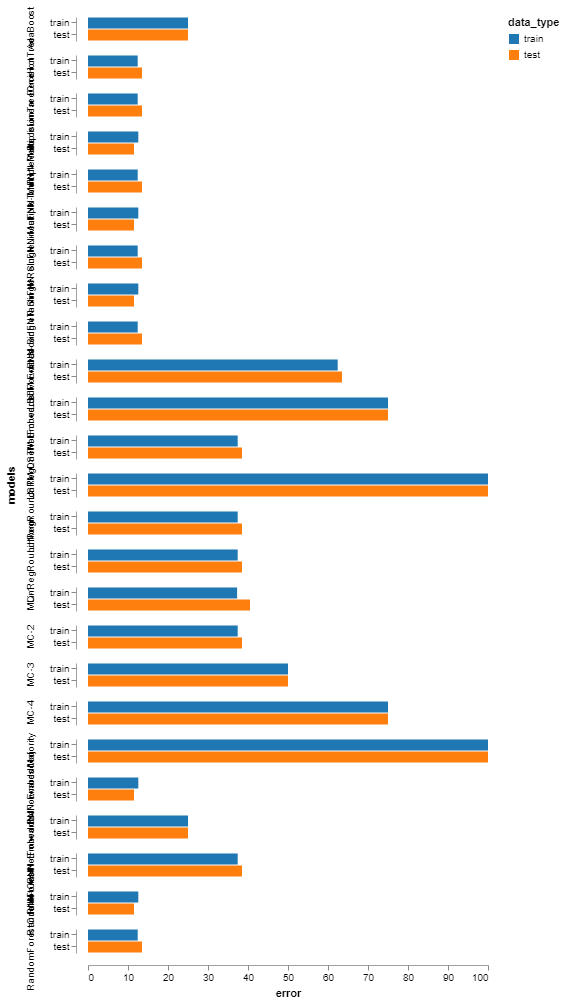

In [47]:
results.grouped_bar('event')

## Train

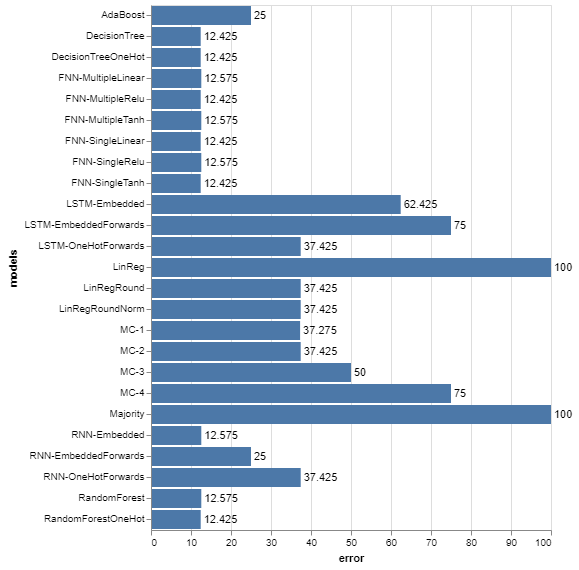

In [48]:
results.graph_results('event', 'train')

## Test

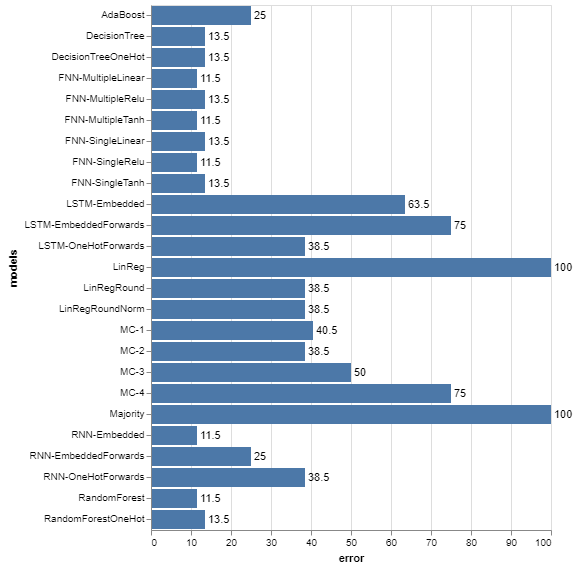

In [49]:
results.graph_results('event', 'test')